# TF Serving of Simple Regression Model

다음 노트북을 따라 한 것임
* ㅁㅁㅁ


In [7]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Regression of the following

$$
y = 2x
$$

Finishing training the model


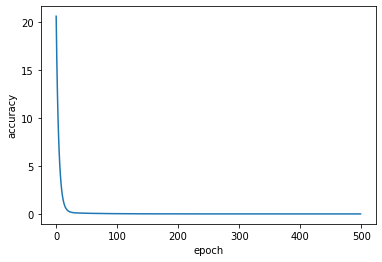

In [49]:
# dataset
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-2.0,  0.0, 2.0, 4.0, 6.0, 8.0], dtype=float)

# model
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
history = model.fit(xs, ys, epochs=500, verbose=0)
print("Finishing training the model")

# visualize training
plt.plot(history.history['loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

## Save the Model 

* Serving을 하기 위해서 SavedModel format으로 저장되어야 한다. 
* as protocol buffer file and with version included path

In [50]:
MODEL_DIR = tempfile.gettempdir()
version = 2
export_path = os.path.join(MODEL_DIR, str(version))  # version to the path

if os.path.isdir(export_path):
    print('\nAlready saved model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")
print('\export_path = {}'.format(export_path))
!ls -l {export_path}


Already saved model, cleaning up

INFO:tensorflow:Assets written to: /tmp/2/assets


INFO:tensorflow:Assets written to: /tmp/2/assets


\export_path = /tmp/2
total 48
drwxr-xr-x 2 hoondori hoondori  4096  4월  6 06:50 assets
-rw-rw-r-- 1 hoondori hoondori 37997  4월  6 06:50 saved_model.pb
drwxr-xr-x 2 hoondori hoondori  4096  4월  6 06:50 variables


## Examine saved model to get MeaGraphDefs and SignatureDefs

In [51]:
!saved_model_cli show --dir {export_path} --all

2021-04-06 06:50:58.908736: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.1/lib64:/usr/local/cuda/extras/CUPTI/lib64
2021-04-06 06:50:58.908755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_6_input'] ten

## Run the tensorflow model server

* rest_api_port 
* model_name
* model_base_path

In [52]:
os.environ['MODEL_DIR'] = MODEL_DIR

In [53]:
%%bash --bg
nohup tensorflow_model_server \
    --rest_api_port=8501 \
    --model_name=hellowWorld \
    --model_base_path="${MODEL_DIR}" > server.log 2>&1

In [54]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-06 06:51:18.883187: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-04-06 06:51:18.903975: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2021-04-06 06:51:18.915329: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/2
2021-04-06 06:51:18.917603: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 83917 microseconds.
2021-04-06 06:51:18.917808: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/2/assets.extra/tf_serving_warmup_requests
2021-04-06 06:51:18.917959: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: hellowWorld 

## Json object로 요청 데이터 만들기

In [55]:
xs = np.array([[9.0], [10.0]])
data = json.dumps({'signature_name': 'serving_default', 'instances': xs.tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[9.0], [10.0]]}


## Inference Request 

In [56]:
headers = {'content-type': 'application/json'}
json_resp = requests.post('http://localhost:8501/v1/models/hellowWorld:predict',
                         data=data, headers=headers)
print(json_resp)
print(json_resp.text)

<Response [200]>
{
    "predictions": [[17.993803], [19.9927521]
    ]
}
